In [7]:
from shared_notebook_utils import *
seaborn.set(style="whitegrid")
%matplotlib inline
datasets = load_datasets(dirnames=None, clean=True)

In [13]:
# First annotate our datasets with confidence measures
for dataset in datasets:
    methods_to_compare = ['Percival14_bpm']
    
    # Annotate all methods wirh confidence measures using the function above
    for key, item in dataset.data.items():
        for method in methods_to_compare:
            try:
                item['analysis'][method]['conf_1ength'] = confidence_measure_audio_length(
                    item['analysis'][method]['bpm'],  
                    item['analysis']['basic_audio_properties']['length_samples'],
                    item['analysis']['basic_audio_properties']['length_samples_effective_duration'],
                    beat_range=range(1,128)
                )
                item['analysis'][method]['conf_1ength_alt'] = confidence_measure_audio_length(
                    item['analysis'][method]['bpm'],  
                    item['analysis']['basic_audio_properties']['length_samples'],
                    item['analysis']['basic_audio_properties']['length_samples_effective_duration'],
                    beat_range=list(set([3*x for x in range(1, 40)] + [2*x for x in range(1, 60)]))  # Multiples of 2 beats and of 3 beats
                )
                item['analysis'][method]['conf_1ength_tree_1'] = confidence_measure_classifier(
                    item['analysis'][method]['conf_1ength'],
                    item,
                    'FSL4',
                    depth=1,
                )
                item['analysis'][method]['conf_1ength_tree_3'] = confidence_measure_classifier(
                    item['analysis'][method]['conf_1ength'],
                    item,
                    'FSL4',
                    depth=3,
                )
                item['analysis'][method]['conf_1ength_tree_10'] = confidence_measure_classifier(
                    item['analysis'][method]['conf_1ength'],
                    item,
                    'FSL4',
                    depth=10,
                )
            except KeyError:
                continue
                
            if method == 'RE13m_bpm':
                # Normalize confidence measure for RE13m_bpm so that numbers go aproximately from 0 to 1 and it is
                # comparable with our confidence measure.
                # Maximum value of conficende is 5.3 according to "Zapata, J., & Holzapfel, A. (2012). Assigning a 
                # Confidence Threshold on Automatic Beat Annotation in Large Datasets. In ISMIR (pp. 157–162)". We
                # therefore normalize so that values are comparable with conficende from other methods.
                item['analysis']['RE13m_bpm']['confidence_essentia'] = float(item['analysis']['RE13m_bpm']['confidence'])/5.3


Overall Percival14_bpm - conf_1ength: 0.69
Overall Percival14_bpm - conf_1ength_tree_1: 0.63
Overall Percival14_bpm - conf_1ength_tree_3: 0.56
Overall Percival14_bpm - conf_1ength_tree_10: 0.57


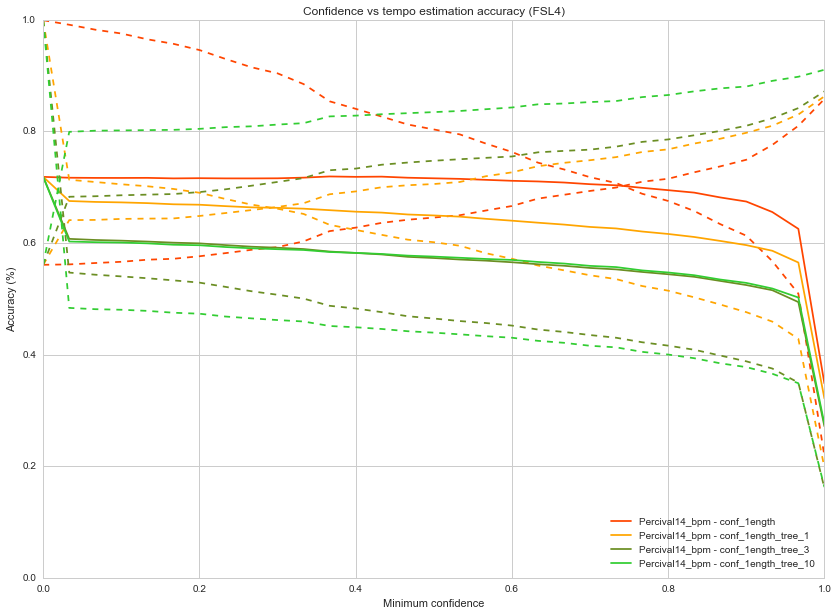

Overall Percival14_bpm - conf_1ength: 0.77
Overall Percival14_bpm - conf_1ength_tree_1: 0.73
Overall Percival14_bpm - conf_1ength_tree_3: 0.67
Overall Percival14_bpm - conf_1ength_tree_10: 0.63


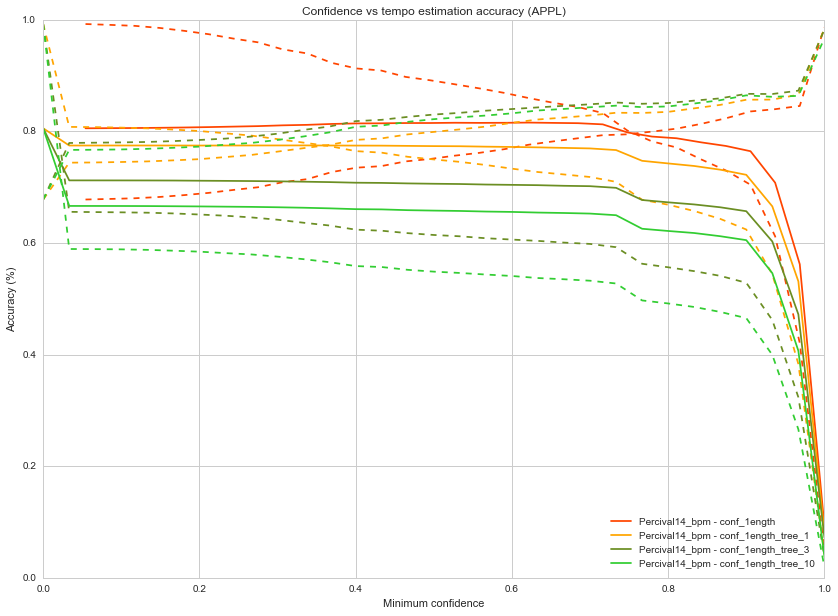

Overall Percival14_bpm - conf_1ength: 0.69
Overall Percival14_bpm - conf_1ength_tree_1: 0.61
Overall Percival14_bpm - conf_1ength_tree_3: 0.52
Overall Percival14_bpm - conf_1ength_tree_10: 0.47


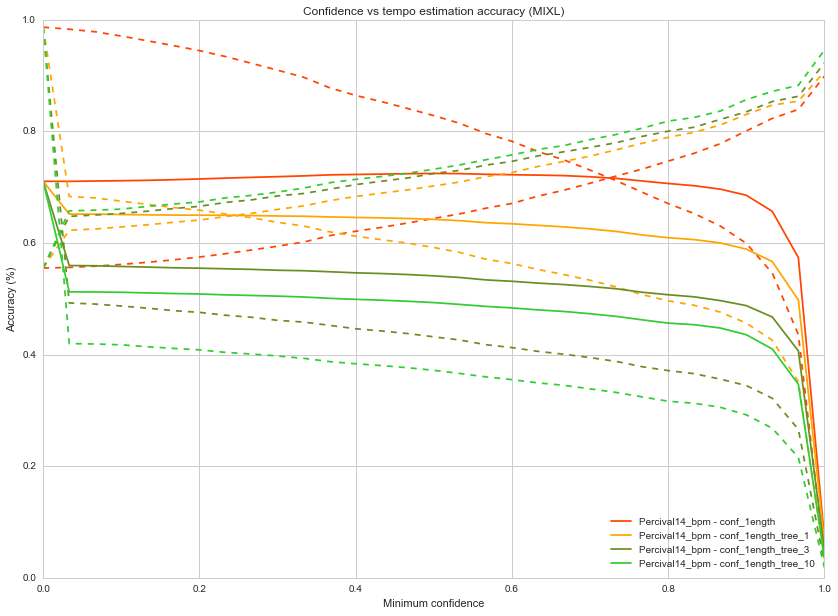

Overall Percival14_bpm - conf_1ength: 0.70
Overall Percival14_bpm - conf_1ength_tree_1: 0.65
Overall Percival14_bpm - conf_1ength_tree_3: 0.58
Overall Percival14_bpm - conf_1ength_tree_10: 0.51


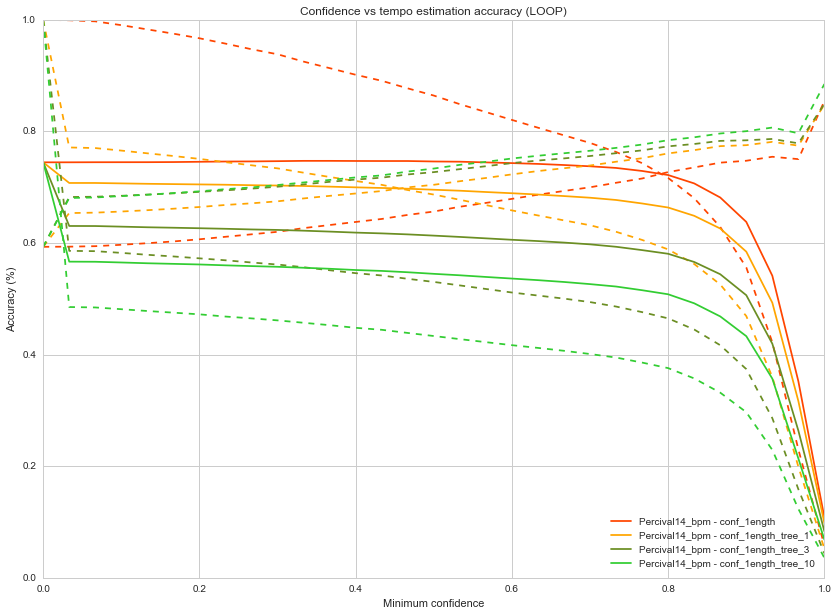

In [14]:
# Now do some plots to compare methods
for dataset in datasets:
    fig, ax1 = plt.subplots(1, 1, figsize=(14, 10))
    methods_to_compare = [('Percival14_bpm', 'conf_1ength'), 
                          # ('Percival14_bpm', 'conf_1ength_alt'), 
                          ('Percival14_bpm', 'conf_1ength_tree_1'),
                          ('Percival14_bpm', 'conf_1ength_tree_3'),
                          ('Percival14_bpm', 'conf_1ength_tree_10'),]
   
    for count, (method, conf_method) in enumerate(methods_to_compare):
        confidences = dataset.get_data('analysis.%s.%s' % (method, conf_method))
        values, edges = np.histogram(confidences, bins=30)
        accuracies_exact = list()
        accuracies_mult = list()
        accuracies_exact_tol4 = list()
        accuracies_mult_tol4 = list()
        counts = list()
        for conf_min in edges:
            filtered_data = dataset.filter_data([('analysis.%s.%s__>=' % (method, conf_method), conf_min)]).data
            if len(filtered_data) >= 3:
                accuracies_exact.append(basic_statistics(metric_close_bpm(filtered_data, method, tolerance=0))['avg'])
                accuracies_exact_tol4.append(basic_statistics(metric_close_bpm(filtered_data, method, tolerance=0.04))['avg'])
                accuracies_mult.append(basic_statistics(metric_multiples_bpm(filtered_data, method, tolerance=0))['avg'])
                accuracies_mult_tol4.append(basic_statistics(metric_multiples_bpm(filtered_data, method, tolerance=0.04))['avg'])
                counts.append(float(len(filtered_data))/len(dataset.data))
        
        mean_accuracies = [np.mean([a,b,c,d]) for a, b, c, d in zip(accuracies_exact,
                                                                   accuracies_exact_tol4,
                                                                   accuracies_mult,
                                                                   accuracies_mult_tol4)]
        fmeasure = [2.0*a*b/(a+b) for a, b in zip(mean_accuracies, counts)]
        
        ax1.plot(edges[:len(mean_accuracies)], mean_accuracies, color=COLORS[count], ls="--")        
        ax1.plot(edges[:len(accuracies_mult)], counts, color=COLORS[count], ls="--")
        ax1.plot(edges[:len(fmeasure)], fmeasure, color=COLORS[count], label="%s - %s" % (method, conf_method))
        
        print 'Overall %s - %s: %.2f' % (method, conf_method, np.mean(fmeasure))

    ax1.set_title('Confidence vs tempo estimation accuracy (%s)' % dataset.short_name)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_xlabel('Minimum confidence')
    ax1.legend(loc=4)
    ax1.set_ylim((0, 1.0))
    ax1.set_yticks([float(ax1.get_ylim()[1])*(float(i)/5) for i in range(0,6)])
    plt.show()